# Single analysis notebook

This notebook aims to create enviroment to simply test strategies developed in Stocks & Loss system for python

In [77]:
# imports 
from scraper import stock_daily
from analyzer import Analyzer
from IPython.display import display
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import indicators as ind

## Settings
* Select stock ticker
* Define buy and sell strategy (buystrat and sellstrat)
* Define if you want to run stop loss and what value
* Same with profit taker

In [78]:
ticker = "MSFT"
# stop loss
sl = True
slval = 0.05
# profit taker
pt = True
ptval = 0.11
# repeteated buys
rb = False

## Running calculation

In [79]:
# scraping / loading data
stock = stock_daily(ticker, save=False, delta=dt.timedelta(days=730))
# creating analyzer instance
trades = Analyzer(ticker=ticker, data=stock.data)

## Building the trade strategy

In [80]:
# ================> Buy strategy: SVF
# STRATEGY DEFINITIONS
# Indicators
vfi = ind.vfi(stock.data, period=30, coef=0.2, vcoef=1.5)
ema3 = ind.ema(stock.data, 3, price="Typical")["EMA"].to_numpy()
ema10 = ind.ema(stock.data, 10, price="Open")["EMA"].to_numpy()
ema26 = ind.ema(stock.data, 26, price="Close")["EMA"].to_numpy()
# buy signal
bcurve = ema3-ema10
ccurve = ema3-ema26
lim = 0.1*stock.data["Close"].to_numpy()
with np.errstate(invalid='ignore'):
    bmask = bcurve > 0
    cmask = (ccurve > -lim).astype("int")
bsig = np.concatenate((np.array([0]), (bmask[:-1] < bmask[1:]))).astype("int")
bsig = np.logical_and(bsig, cmask).astype("int")
# VFI mask
vfimask = (vfi["vfi"] > 0).to_numpy()
vfimask = np.logical_or(vfimask, (vfi["histogram"] > 0).to_numpy())
bsf = np.logical_and(bsig, vfimask).astype("int")
# throw exception if buy signal is empty
if bsf.sum() == 0:
    raise RuntimeError("No buy signals were generated by this strategy.")

# WRITE SELL METHOD WHICH CREATES 
# ================> Sell strategy: SMA cross
# for N buy signals, create N sell vectors where Nth column will be the sell signal for Nth buy signal, 
# some sell methods that are independent will have copied columns

ss = np.roll(bsf,3)
ssf = np.repeat([ss,], repeats=np.sum(bsf), axis=0)

# sort signals
ss = trades.signalSorter(bsf,ssf,rb) 

In [81]:
# building final strategy
trades.strategy(ss, stopLoss=sl, stopLossValue=slval, profitTaker=pt, profitTakerValue=ptval)
# evaluating strategy
summary = trades.profit(capitalForEachTrade=500, comission=2)
profitByHolding = 100*((trades.data["Close"].iloc[-1]-trades.data["Close"].iloc[0])/trades.data["Close"].iloc[0])

# dates for plot
# taking stock.data and changing index to column and Date to index
dates = stock.data.copy()
dates["index1"] = dates.index
dates = dates.set_index("Date")

# find index of buy dates of good trades
bdg = summary["Buy date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdg = summary["Sell date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdg = dates["index1"].reindex(bdg).to_numpy()
sdg = dates["index1"].reindex(sdg).to_numpy()
   
# find index of buy dates of bad trades
bdb = summary["Buy date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdb = summary["Sell date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdb = dates["index1"].reindex(bdb).to_numpy()
sdb = dates["index1"].reindex(sdb).to_numpy()

# Results

In [82]:
print('Absolute profit last year:                ',np.round(summary["Profit[$]"].sum(),2),'$')
print('Relative profit last year:                ',np.round(summary["Profit[%]"].sum(),2),'%')
print('Relative profit by holding last year:     ',np.round(profitByHolding,2),'%')

Absolute profit last year:                 -11.26 $
Relative profit last year:                 -2.25 %
Relative profit by holding last year:      121.84 %


In [83]:
display(summary)

,Buy date,Buy price,Buy value,Position,Sell date,Sell price,Sell value,Comission,Good trade?,Profit[$],Profit[%]
0,2020-01-28,162.661621,500,3.073866,2020-01-31,167.350922,514.414281,2,1.0,12.414281,2.482856
1,2020-03-26,153.888931,500,3.249097,2020-03-31,155.466171,505.124605,2,1.0,3.124605,0.624921
2,2020-04-29,174.905609,500,2.858685,2020-05-04,176.295532,503.973352,2,1.0,1.973352,0.394670
3,2020-05-15,180.554062,500,2.769254,2020-05-20,183.528229,508.236223,2,1.0,6.236223,1.247245
4,2020-06-02,182.786835,500,2.735427,2020-06-05,185.050537,506.192192,2,1.0,4.192192,0.838438
5,2020-07-21,206.353104,500,2.423031,2020-07-24,196.035448,475.000000,2,0.0,-27.000000,-5.400000
6,2020-08-03,214.053650,500,2.335863,2020-08-06,213.865845,499.561313,2,0.0,-2.438687,-0.487737
7,2020-09-28,207.535629,500,2.409225,2020-10-01,210.528198,507.209772,2,1.0,5.209772,1.041954
8,2020-11-04,214.422455,500,2.331845,2020-11-09,216.404282,504.621314,2,1.0,2.621314,0.524263
9,2020-12-14,212.808060,500,2.349535,2020-12-17,217.994141,512.184879,2,1.0,10.184879,2.036976


## Visualizations

Successful trades are showcased as a light green fill, similarly, failed trades as a red fill

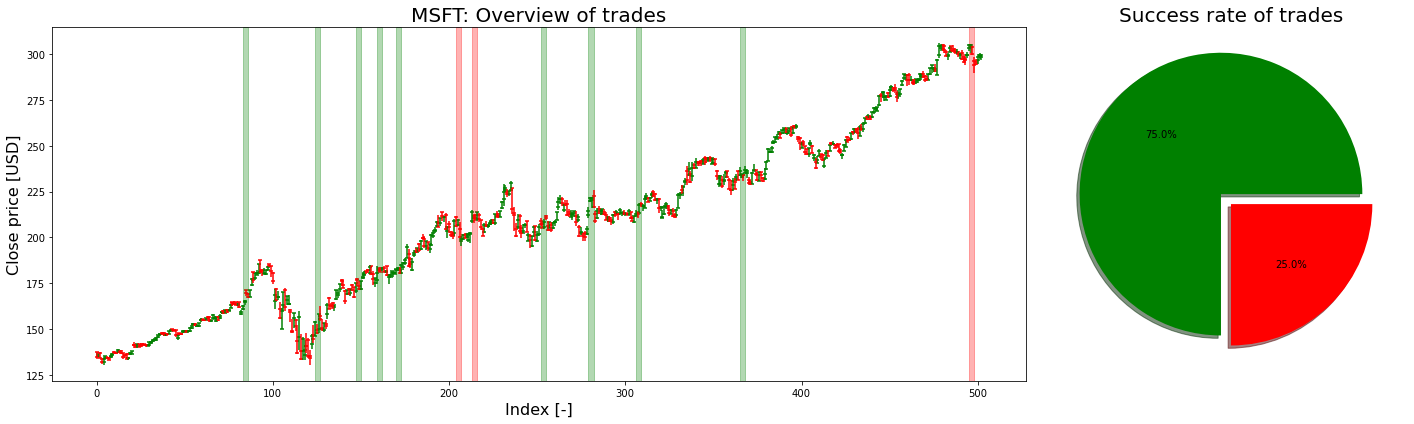

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw={'width_ratios': [2.5, 1]})

green = stock.data.index.where(stock.data["Close"] >= stock.data["Open"])
red = stock.data.index.where(stock.data["Close"] < stock.data["Open"])

# plot closed prices and highlighted trades
ax[0].vlines(green, stock.data["Low"], stock.data["High"], color="g")
ax[0].scatter(green, stock.data["Open"], marker="_", color="g", s=10)
ax[0].scatter(green, stock.data["Close"], marker="_", color="g", s=10)
ax[0].vlines(red, stock.data["Low"], stock.data["High"], color="r")
ax[0].scatter(red, stock.data["Open"], marker="_", color="r", s=10)
ax[0].scatter(red, stock.data["Close"], marker="_", color="r", s=10)
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlabel("Index [-]", fontsize=16)

gtrades = summary["Good trade?"].sum()
btrades = summary["Good trade?"].size
# plot piechart with percentage of succesful trades (profit / loss)
ax[1].pie([gtrades, btrades-gtrades], colors=["g","r"], shadow=True, explode=(0.1, 0), autopct="%1.1f%%")
ax[1].set_title("Success rate of trades", fontsize=20)

fig.tight_layout()

Text(0, 0.5, 'VFI')

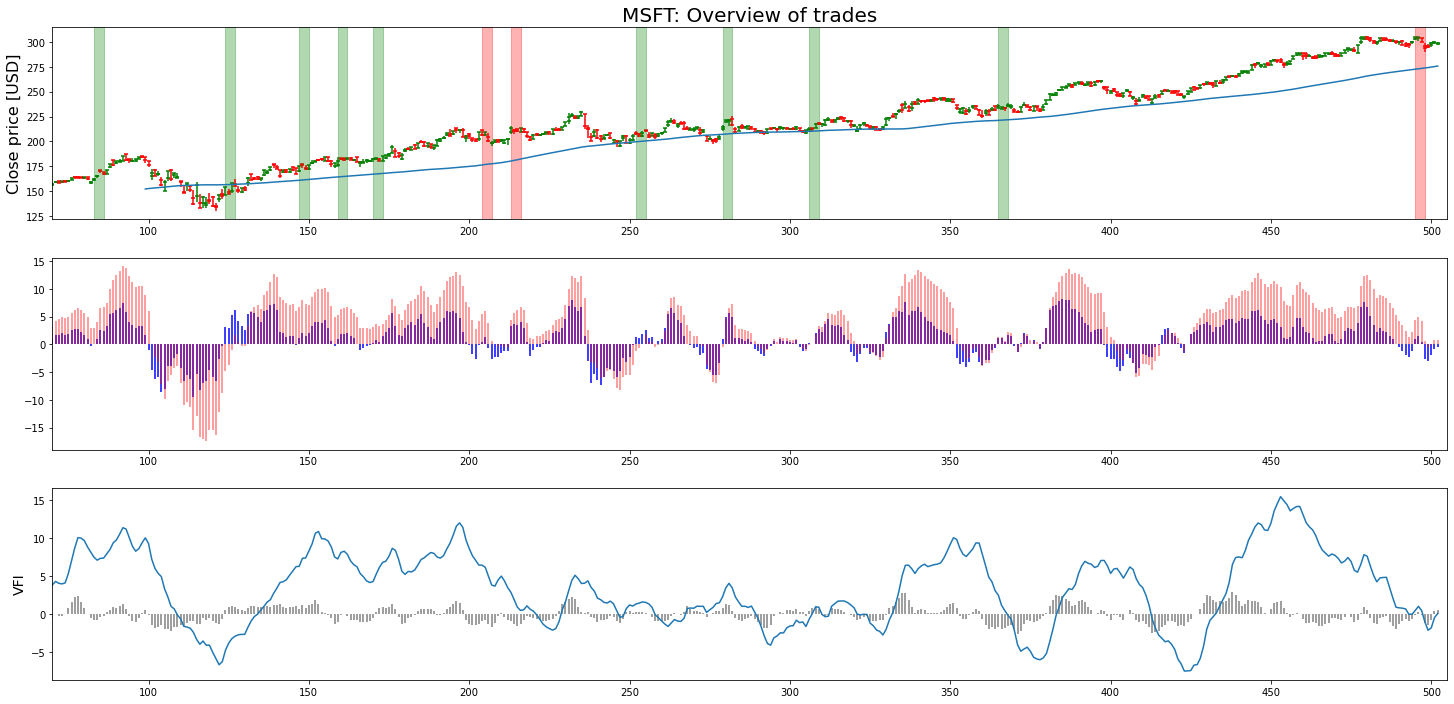

In [85]:
fig, ax = plt.subplots(nrows=3, figsize=(25,12))

# plot closed prices and highlighted trades
ax[0].vlines(green, stock.data["Low"], stock.data["High"], color="g")
ax[0].scatter(green, stock.data["Open"], marker="_", color="g", s=10)
ax[0].scatter(green, stock.data["Close"], marker="_", color="g", s=10)
ax[0].vlines(red, stock.data["Low"], stock.data["High"], color="r")
ax[0].scatter(red, stock.data["Open"], marker="_", color="r", s=10)
ax[0].scatter(red, stock.data["Close"], marker="_", color="r", s=10)

ax[0].plot(ind.sma(stock.data, 100)["SMA"])
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlim([70, 505])

ax[1].vlines(stock.data.index, 0, bcurve, "b")
ax[1].vlines(stock.data.index, 0, ccurve, "r", alpha=0.5)
ax[1].set_xlim([70, 505])

# plot VFI
vfi = ind.vfi(stock.data, period=30, coef=0.2, vcoef=1.5)
ax[2].plot(vfi["vfi"])
ax[2].vlines(stock.data.index, 0, vfi["histogram"], "k", alpha=0.5)
ax[2].set_xlim([70, 505])
ax[2].set_ylabel("VFI", fontsize=14)

# # Plot double stochastic oscillator, 21 and 5
# st_fast = ind.stoch(stock.data, period=21, sk=2, sd=5)
# st_slow = ind.stoch(stock.data, period=5, sk=2, sd=3)
# ax[1].plot(st_slow["k"], "b--", alpha=0.4)
# ax[1].plot(st_slow["d"], "b", alpha=0.4)
# ax[1].plot(st_fast["k"], "c--", alpha=0.4)
# ax[1].plot(st_fast["d"], "c", alpha=0.4)
# ax[1].fill_between(np.arange(stock.data.shape[0]), st_slow["k"], st_slow["d"], where=(st_slow["k"] >= st_slow["d"]), interpolate=True, facecolor="green", alpha=0.4)
# ax[1].fill_between(np.arange(stock.data.shape[0]), st_slow["k"], st_slow["d"], where=(st_slow["k"] < st_slow["d"]), interpolate=True, facecolor="red", alpha=0.4)
# ax[1].fill_between(np.arange(stock.data.shape[0]), st_fast["k"], st_fast["d"], where=(st_fast["k"] >= st_fast["d"]), interpolate=True, facecolor="green", alpha=0.4)
# ax[1].fill_between(np.arange(stock.data.shape[0]), st_fast["k"], st_fast["d"], where=(st_fast["k"] < st_fast["d"]), interpolate=True, facecolor="red", alpha=0.4)
# # plot y line
# ax[1].plot(np.arange(stock.data.shape[0]), 80*np.ones(stock.data.shape[0]), "k--")
# ax[1].plot(np.arange(stock.data.shape[0]), 50*np.ones(stock.data.shape[0]), "r--")
# ax[1].plot(np.arange(stock.data.shape[0]), 20*np.ones(stock.data.shape[0]), "k--")
# ax[1].set_xlim([0, stock.data.shape[0]])

# # plot VFI
# ax[2].plot(vfi["vfi"])
# ax[2].plot(vfi["vfi_smooth"])
# ax[2].set_xlim([0, stock.data.shape[0]])
# ax[2].set_xlabel("Index [-]", fontsize=16)

In [86]:
# saving SVF buy signal strategy

# # calculating VFI
# vfi = ind.vfi(stock.data, period=30, coef=0.2, vcoef=1.5)
# fs = ind.stoch(stock.data, period=5, sk=2, sd=3)
# # calculating VFI histogram trend
# window = 2
# vfi_hist = vfi["histogram"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
# vfi_hist = vfi_hist > 0
# # VFI trend
# vfi_trend = vfi["vfi"] > vfi["vfi_smooth"]
# vfi_conf = np.logical_or(vfi_hist, vfi_trend)
# # calculating fast stochastic trend
# window = 4
# fs_conf = fs["k"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
# fs_conf = fs_conf > 0
# # buy signals in uptrend
# bss = trades.mb_stoch(period=21, sk=2, sd=5, treshold=0, tcross="d")
# # finalize buy signals
# bsf = np.logical_and(np.logical_and(fs_conf, vfi_conf), bss)